# Airspace Technologies Technical Screening - Luis A. Hernandez

## Import data and corresponding libraries

In [1]:
#By convention, let's start by importing the libraries we will need for this brief analysis.
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import json

In [2]:
#Let's start by importing the file we are going to work with.
aspace_orders = []
with open('order_records.log') as file:
    for row in file:
        aspace_orders.append(row)

## Cleaning section

Once imported, I wanted to familiarize myself with the data. Given that I now had a list of strings with the data embedded inside, the following steps to clean it up was to eliminate extra parts of strings within each element of the list, pass it onto a dictionary and eventually generate a dataframe that could be used for the analysis section.

In [3]:
aspace_orders[0]

"0,{'order_id': 21000, 'package': {'weight': 326, 'volume': 62018, 'imperial_unit': 'false'},'service_line': 34}\n"

In [4]:
#Now that we have the file, the next thing to do is to clean it up.
#We can start by getting rid of the last row since it is empty.
aspace_orders = aspace_orders[:1000]

In [5]:
#Next, we can see that there is an explicit output of the newline in each row.
#To eliminate this from the data, we can filter this out through a list comprehension.
aspace_orders = [i[:-1] for i in aspace_orders]

In [6]:
#Similarly, we can also eliminate the row index as well as any extra string elements in the beginning of each row.
#First, I captured the index up to the point where I want to clean up this data.
dex = [j.index('{') for j in aspace_orders]

In [7]:
#Now that I have the indices, I can get rid of the extra strings at the beginning of each row.
aspace_orders = [aspace_orders[k][dex[k]:] for k in range(len(dex))]

In [8]:
#Next, let's flip single quotes with double quotes and vice-versa 
#in order to prepare the dataset for a dictionary transformation that can be more practically manipulated
#in the preparation for the dataframe.
aspace_orders = [str(l).replace("'",'"') for l in aspace_orders]

In [9]:
#As mentioned, let's now transform to a more practical list of dictionaries.
dict_asporders = [json.loads(m) for m in aspace_orders]

In [10]:
#From here, what is left is the extraction of the 'package' data and the deletion of this key-value pair.
[dict_asporders[m].update(dict_asporders[m]['package']) for m in range(len(dict_asporders))];
[p.pop('package') for p in dict_asporders];

In [11]:
#Now that I have a well organized dictionary, 
#by convention I can now generate a dataframe that can further aide us in our analysis.
airspace_orders_df = pd.DataFrame.from_dict(dict_asporders)

From this point on, I could have generated some quick stats, but given that there were different unit measurements being used, I initially thought it was a better idea if everything was converted into the imperial units, since we are in the United States (I later realized that this was not needed for my model, but I still present it to show that the first choice model-linear regression-was worked on). 

In [12]:
#Quick view of our dataframe.
airspace_orders_df.head()

,order_id,service_line,weight,volume,imperial_unit
0,21000,34,326,62018,false
1,21001,34,460,110592,false
2,21002,88,500,1440,false
3,21003,34,260,100700,true
4,21004,88,168,20700,true


In [13]:
#Copy dataframe for a later use.
aspace_df = airspace_orders_df.copy()

In [14]:
#Multiplying by the corresponding factor to bring them to Imperial units, we get:
airspace_orders_df.loc[airspace_orders_df['imperial_unit'] == 'false','weight'] = airspace_orders_df[airspace_orders_df['imperial_unit'] == 'false']['weight'] * 2.2
airspace_orders_df.loc[airspace_orders_df['imperial_unit'] == 'false','volume'] = airspace_orders_df[airspace_orders_df['imperial_unit'] == 'false']['volume'] * 0.061

In [15]:
#Generating a new dataframe, I have dropped off the 'imperial_unit' column,
#and have renamed the weight and volume column to include the units.
orders_df = airspace_orders_df.drop(['imperial_unit'], axis = 1).rename(columns={'weight':'weight(lbs)','volume':'vol(in^3)'})
orders_df['service_line'] = orders_df['service_line'].astype(float)
#Let's take a quick look at how our data looks like now:
orders_df.head()

,order_id,service_line,weight(lbs),vol(in^3)
0,21000,34.0,717.2,3783.098
1,21001,34.0,1012.0,6746.112
2,21002,88.0,1100.0,87.840
3,21003,34.0,260.0,100700.000
4,21004,88.0,168.0,20700.000


## Analysis Section

Since this was an open ended question, it was initially a little challenging to go in a particular direction even though once I saw the true-false imperial_unit column, the logistic regression alarm was raised in my head. Nonetheless, I still stuck with linear regression to see if I could apply it to the dataset in another response variable that I also had in mind - service line. 

In [16]:
#So, starting off the stats values I got were:
orders_df.describe()

,order_id,service_line,weight(lbs),vol(in^3)
count,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,21509.500000,49.386000,833.443800,1.817159e+04
std,424.715945,16.201342,2809.330844,6.517969e+04
min,21000.000000,14.000000,4.400000,6.100000e-02
25%,21249.750000,34.000000,220.000000,1.721755e+03
50%,21500.500000,34.000000,385.000000,3.325720e+03
75%,21750.250000,65.000000,787.050000,1.014552e+04
max,31348.000000,88.000000,79774.200000,1.555200e+06


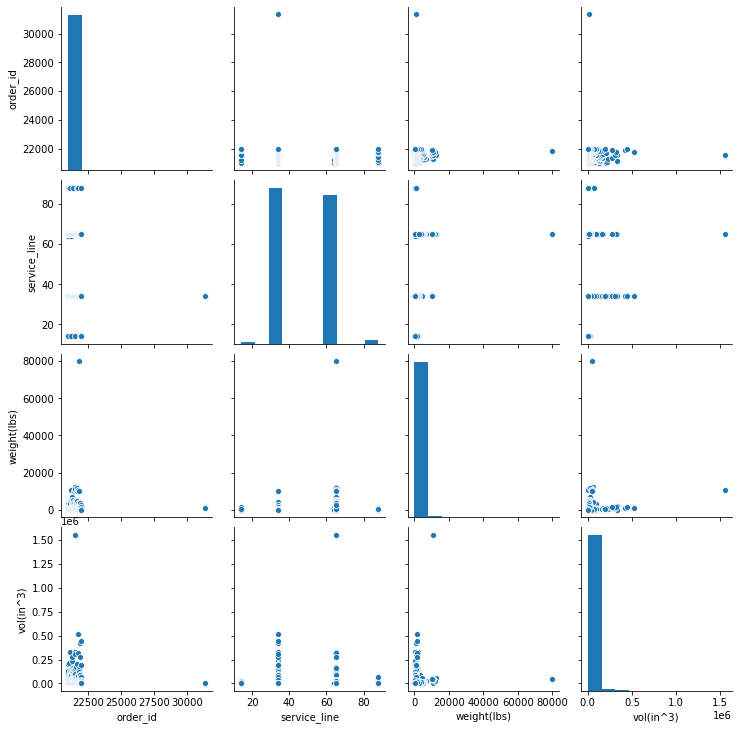

In [17]:
#Next, I tried to see if there are any correlations between the variables via seaborn's pairplot.
sns.pairplot(orders_df)

Here, I could see that there were some values sticking out beyond most of our data points in particular locations. To me this could be an indication of outliers, but before that I wanted to double check explicitly if there was or wasn't  a relationship between the variables through the correlation coefficients.

In [18]:
orders_df['weight(lbs)'].corr(orders_df['vol(in^3)'])

0.12626921742470976

In [19]:
orders_df['service_line'].corr(orders_df['vol(in^3)'])

-0.015487794357448082

In [20]:
orders_df['weight(lbs)'].corr(orders_df['service_line'])

0.11364687801454401

Seeing that there was no clear linear relationship (yet), the next thing to do was to see what was up with the extreme values I previously mentioned. 

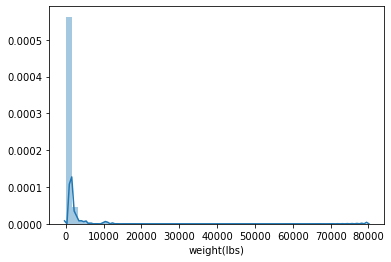

In [21]:
#Generated a barplot for the 'weight(lbs)' data.
sns.distplot(orders_df['weight(lbs)'])

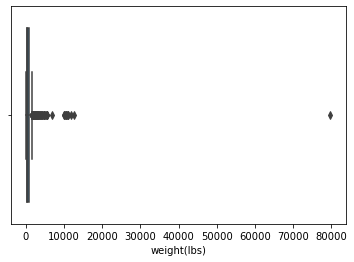

In [22]:
#Generated a boxplot for the 'weight(lbs)' data.
sns.boxplot(orders_df['weight(lbs)'])

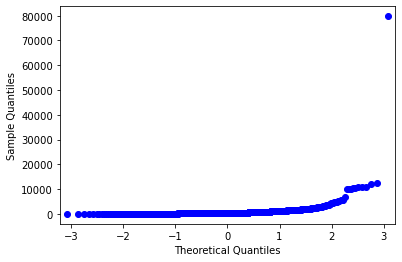

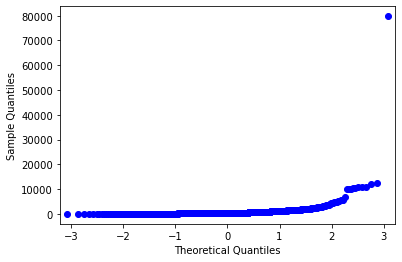

In [23]:
#Generated qqplot for the 'weight(lbs)' data.
sm.qqplot(orders_df['weight(lbs)'])

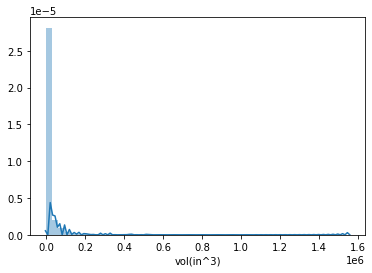

In [24]:
#Generated a barplot for the 'vol(in^3)' data.
sns.distplot(orders_df['vol(in^3)'])

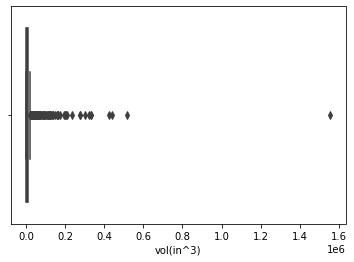

In [25]:
#Generated a barplot for the 'vol(in^3)' data.
sns.boxplot(orders_df['vol(in^3)'])

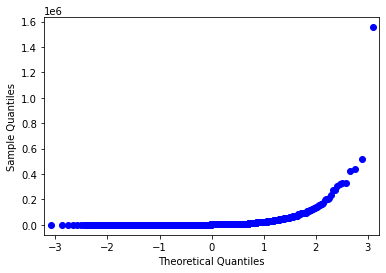

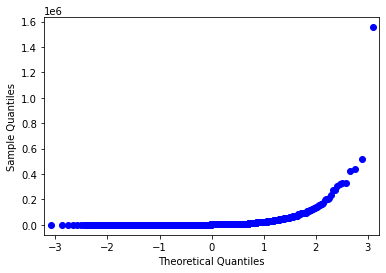

In [26]:
#Generated a qqplot for the 'vol(in^3)' data.
sm.qqplot(orders_df['vol(in^3)'])

Undoubtedly, there was a clear indication from all of the plots that there were outliers in this dataset, the next thing to do was to figure out which ones were the ones that would be omitted for the analysis. My initial thought was to omit datapoints that had a density which exceeded the most dense material we currently know about; once this was done, the next thing I considered was to omit values based on maximum values allowed for logistics transport in the United States. Upon further research and finding that the amount of datapoints omitted still did not generate a decent coefficient of determination output, I went ahead and used the interquartile range to replicate the boxplot cutoff section beyond the whiskers (to one cycle). Source: https://en.wikipedia.org/wiki/Interquartile_range

In [27]:
#Filtered outliers for the 'weight(lbs)' column.
lbs_diff = orders_df['weight(lbs)'].quantile(0.75) - orders_df['weight(lbs)'].quantile(0.25)
orders_df1 = orders_df.loc[(orders_df['weight(lbs)'] >= orders_df['weight(lbs)'].quantile(0.25) - 1.5 * lbs_diff) 
                           &(orders_df['weight(lbs)'] <= orders_df['weight(lbs)'].quantile(0.75) + 1.5 * lbs_diff)].reset_index(drop=True)

In [28]:
#Filtered outliers for the 'vol(in^3)' column.
vol_diff = orders_df1['vol(in^3)'].quantile(0.75) - orders_df1['vol(in^3)'].quantile(0.25)
orders_df1 = orders_df1.loc[(orders_df1['vol(in^3)'] >= orders_df1['vol(in^3)'].quantile(0.25) - 1.5 * vol_diff) 
                            &(orders_df1['vol(in^3)'] <= orders_df1['vol(in^3)'].quantile(0.75) + 1.5 * vol_diff)].reset_index(drop=True)

Seeing once again if there was a linear relationship between the factors and the response variable - service_line - there was a small indication of it being there, but it was still not strong enough.

In [29]:
#Generated correlation coefficient for 'weight(lbs)' column.
orders_df1['weight(lbs)'].corr(orders_df1['service_line'])

0.21905465517210496

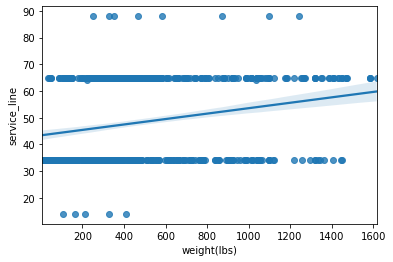

In [30]:
#Generated scatterplot to see relationship between 'service_line' and 'weight(lbs)'.
sns.regplot(data=orders_df1,x='weight(lbs)',y='service_line')

In [31]:
#Generated correlation coefficient for 'vol(in^3)' column.
orders_df1['vol(in^3)'].corr(orders_df1['service_line'])

-0.22297248496054758

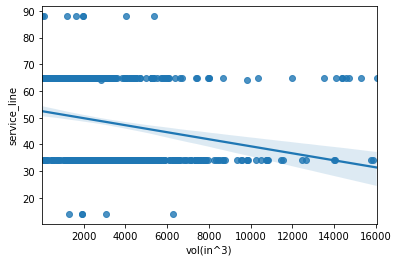

In [32]:
#Generated scatterplot to see relationship between 'service_line' and 'vol(in^3)'.
sns.regplot(data=orders_df1,x='vol(in^3)',y='service_line')

Performing a thorough exploration and preparation of the data for analysis, I finally was able to see how it performed with two models. As previously mentioned, my first intention was to perform a logistic regression (which is the second one presented in the section below), but I wanted to see if I could go a little more basic with linear regression, which is what I start off with in the next section.

## Machine Learning Section: Linear Regression

In [33]:
#Defining the variables to be used for the linear regression model,
#I went ahead and split the dataset with a corresponding breakoff point at 75-25 for the training and test sets.
x=orders_df1[['vol(in^3)','weight(lbs)']]
y=orders_df1[['service_line']]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [34]:
#Next, the model is performed on the dataset.
model = LinearRegression().fit(x,y)
#Viewing the coefficient of determination (R^2) for the training dataset, I got:
model.score(x_train,y_train)

0.21241859285259979

In [35]:
#Generating a good value in the previous line, let's now see how it performs up against the test dataset.
model.score(x_test,y_test)

0.011559784620301161

Performing poorly mainly due to the weak linear relationship from the start, this model was not satisfactory and so, this indicated that a slightly different direction had to be taken. Going with my second option, I went ahead and pivoted to see if a logistic regression could perform a little better on the dataset.

## Machine Learning Section: Logistic Regression

Choosing the 'imperial_unit' column as the response variable, I transformed all of the false values to 0 and the true values to 1. Previous steps taken to eliminate outliers were also performed, namely, the boxplot innerquartile range that places the whisker extremes as my maximums and minimums.

In [36]:
#Transform boolean values to their binary counterpart and fully change the data type of 'service_line' column to int.
aspace_df['imperial_unit'] = [0 if i=='false' else 1 for i in airspace_orders_df['imperial_unit']]
aspace_df['service_line'] = [int(i) for i in aspace_df['service_line']]

In [37]:
#Filtered outliers for the 'weight' column.
weight_diff = aspace_df['weight'].quantile(0.75) - aspace_df['weight'].quantile(0.25)
aspace_df1 = aspace_df.loc[(aspace_df['weight'] >= aspace_df['weight'].quantile(0.25) - 1.5 * weight_diff) 
                           &(aspace_df['weight'] <= aspace_df['weight'].quantile(0.75) + 1.5 * weight_diff)].reset_index(drop=True)

In [38]:
#Filtered outliers for the 'volume' column.
volume_diff = aspace_df1['volume'].quantile(0.75) - aspace_df1['volume'].quantile(0.25)
aspace_df1 = aspace_df1.loc[(aspace_df1['volume'] >= aspace_df1['volume'].quantile(0.25) - 1.5 * volume_diff) 
                            & (aspace_df1['volume'] <= aspace_df1['volume'].quantile(0.75) + 1.5 * volume_diff)].reset_index(drop=True)

In [39]:
#Here, an extra step had to be taken to further improve the model's performance on the dataset, 
#namely, the normalization of our factor variables.
scaler = MinMaxScaler()
scaler.fit(aspace_df1[['service_line','weight','volume']].to_numpy())

MinMaxScaler()

In [40]:
#Defining once again the corresponding variables to be used in the logisitic regression, 
#I went ahead and also did a 90-10 breakoff point for the training and test set split.
lx = scaler.transform(aspace_df1[['service_line','weight','volume']].to_numpy())
ly = aspace_df1['imperial_unit'].to_numpy()
lx_train,lx_test,ly_train,ly_test = train_test_split(lx,ly,test_size=0.1,random_state=0)

In [41]:
#Defining the model and it's hyperparameters.
lmodel = LogisticRegression(solver='liblinear',multi_class='ovr')

In [42]:
#Performing the model on the training set, 
#the coefficient of determination for the same set is.
lmodel.fit(lx_train,ly_train)
lmodel.score(lx_train,ly_train)

0.8038709677419354

In [43]:
#And finally, applying it to the test set, I got the following r^2 value:
lmodel.score(lx_test,ly_test)

0.8620689655172413

Performing much better than the previous model, the r^2 value of 0.86 is quite satisfactory for a model performance. The remaining steps pending are (1) to alternatively see how our model performs in imperial_unit measurement prediction based on the factor values, and (2) a cross validation method that could have been taken to see how the model performs given the dataset size.

In [44]:
#Starting off with the probabilities of either encountering an imperial unit or not,
#I show these below:
lmodel.predict_proba(lx_test)[1:5]

array([[0.82198698, 0.17801302],
       [0.79643489, 0.20356511],
       [0.81892582, 0.18107418],
       [0.77966691, 0.22033309]])

In [45]:
#Surprised to find that there were rarely any changes in the probabilities, 
#I wanted to double check this with a predicted output using the test dataset.
y_pred = lmodel.predict(lx_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Strickingly enough, this made me scratch my head for quite a while, but given the size of the dataset along with the overwhelming skewness that it has with the imperial_unit column being false, this made sense. Wanting to proceed with a further evaluation of the model via a confusion matrix, precision score, and specificity score, I was limited by the response variable prediction solution, so I ended here with my main analysis. As to this next portion, I present an alternative method of model evaluation that could have been taken given the size of this dataset and to show any selection bias that could have been present in the previous evaluation; regardless, the r^2 value still held consistent with previous findings and can be considered to be overall satisfactory.

In [46]:
#Define a dataframe of cross validation r^2 values.
cv_df = pd.Series(cross_val_score(lmodel,lx,ly,cv=10))
#Generate stats of model performace using cross validation.
cv_df.describe()

count    10.000000
mean      0.809757
std       0.005471
min       0.802326
25%       0.804598
50%       0.813953
75%       0.813953
max       0.813953
dtype: float64